# Introduction
## Question
How have the lyrics of the most popular songs in the US changed over time?
## Why Does It Matter?
From lullabies to birthday to dirges, music color and reflect our experiences. Music provides insight in the culture, norms, rituals, and values of a society. I am interested in observing the zeitgeist of the US through the years and how it changes. In relation to the data, I am interested in what popular music--specifically the number one single in Billboard's charts--can say about the people in the era and society.

Although the most popular song is decided by a wide variety of factors, one of the factors is the appeal to the general public, which is why I can gain insight to the time period through its  popular songs. It may bold assumption to make, but I think the lyrics of the songs every decade would be able to at least reflect, if not the zeitgeist,  some aspect of the culture at that decade.
# Sources
I am defining most popular song in the US as the #1 Billboard single in that decade. I’m getting the information of the #1 Billboard single from Wikipedia articles with links of the form “https://en.wikipedia.org/wiki/Billboard_year-end_top_30_singles_of_(year)”.

I’m using the Wikipedia articles as my source of information because I know Wikipedia allows web scraping. I've compared it with several other websites and the information matches up, so I think this is a trustworthy source.

I’m getting the lyrics by Googling the name of the songs and finding the first relevant results that don’t including [CHORUS] [VERSE 1] and the like. It’s much more manual but I haven’t found a less labor-intensive method of finding lyrics, especially for some of the older songs.

# Workflow
1. Collect songs from Wikipedia in the Jupyter notebook `Collecting Billboard Top 100 From Wikipedia`.
2. Import it into Google Sheets and manually populate the "Lyrics" column.
3. Export it as a .csv file and import it into this Jupyter notebook for data exploration.

# Assumptions & Concerns
I am using an equal number of songs from each decade to combat imbalances.
However, since I need to manually input the lyrics, the number of songs used is very few so I may end up drawing wrong conclusions based on unique characteristics of the specific songs I chose. Because of that, I'm making a huge assumption that my data is representative of the whole decade. However, I'm adding more lyrics to the list and re-running everything so I hope as I add more data, the assumption will become less of a stretch.
The underlying phenomena is the zeitgeist of each decade, and I am using the lyrics of the popular songs as a latent variable to investigate this.

Subsets:
1. 7 data points
    * #1 song in 1950, 1960, 1970, 1980, 1990, 2000, 2010
2. 14 data points
    * #1 song in 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015
3. 28 data points
    * #1 & #2 songs in 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015
    
# Tools & Methods
## Preliminary Importing

In [1]:
import nltk #
from nltk import pos_tag #
from nltk.corpus import stopwords #
from nltk.tokenize import word_tokenize #
from nltk.stem import WordNetLemmatizer #
from nltk.corpus import wordnet #
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from collections import Counter
from string import punctuation #

import pandas as pd #
import numpy as np #
from matplotlib import pyplot as plt #
%matplotlib inline
plt.style.use("seaborn-pastel")

# Data

In [2]:
#This is the saved csv file from Google Sheets with lyrics added to web-scrapped data
full_music = pd.read_csv("Lyrics_Billboard100_1950-2018.csv")
pd.to_numeric(full_music["Year"])
#Get the songs from the Billboard entries every 5 years
subset_music = full_music.loc[full_music["Year"]%5 == 0]
#Only get the #1 and #2 song in each Billboard entry
data = subset_music.loc[subset_music["Position"].isin(["1", "2"])].reset_index(drop=True)
data

,Position,Song,Artist,Year,Lyrics
0,1,"""Goodnight Irene""",Gordon Jenkins & The Weavers,1950,"Irene, goodnight\nIrene, goodnight\nGoodnight,..."
1,2,"""Mona Lisa""",Nat King Cole,1950,"Mona lisa, mona lisa, men have named you\nyou'..."
2,1,"""Cherry Pink And Apple Blossom White""",Perez Prado,1955,It's cherry pink and apple blossom white\nWhen...
3,2,"""Rock Around the Clock""",Bill Haley & His Comets,1955,"One, two, three o'clock, four o'clock, rock\nF..."
4,1,"""Theme from A Summer Place""",Percy Faith,1960,There's a summer place\nWhere it may rain or s...
5,2,"""He'll Have to Go""",Jim Reeves,1960,Put your sweet lips a little closer to the pho...
6,1,"""Wooly Bully""",Sam the Sham and the Pharaohs,1965,"Uno, dos, one, two, tres, quatro\nMatty told H..."
7,2,"""I Can't Help Myself (Sugar Pie Honey Bunch)""",Four Tops,1965,"Ooh, sugar pie, honey bunch\nYou know that I l..."
8,1,"""Bridge Over Troubled Water""",Simon & Garfunkel,1970,"When you're weary, feeling small\nWhen tears a..."
9,2,"""(They Long to Be) Close to You""",The Carpenters,1970,Why do birds suddenly appear\nEvery time you a...


In [80]:
#Remove punctuation
data["Lyrics w/o Punctuation"] = [lyrics.lower().replace("\n"," ").translate(str.maketrans('', '', punctuation)) 
                                  for lyrics in data["Lyrics"]]
#Word tokenize
data["Lyrics by Words"] = [word_tokenize(lyrics) for lyrics in data["Lyrics w/o Punctuation"]]
#Create a decade column
data["Decade"] = [int(year/10) for year in data["Year"]]
music = data.groupby("Decade").agg(list)
music["Decade"] = [str(year[0])+"s" for year in music["Year"]]
#Create a table with the decade and the lyrics of the top 2 songs in XXX0 and XXX5
music = music.reset_index(drop=True)[["Decade", "Lyrics", "Lyrics w/o Punctuation", "Lyrics by Words"]]
music

,Decade,Lyrics,Lyrics w/o Punctuation,Lyrics by Words
0,1950s,"[Irene, goodnight\nIrene, goodnight\nGoodnight...",[irene goodnight irene goodnight goodnight ire...,"[[irene, goodnight, irene, goodnight, goodnigh..."
1,1960s,[There's a summer place\nWhere it may rain or ...,[theres a summer place where it may rain or st...,"[[theres, a, summer, place, where, it, may, ra..."
2,1970s,"[When you're weary, feeling small\nWhen tears ...",[when youre weary feeling small when tears are...,"[[when, youre, weary, feeling, small, when, te..."
3,1980s,"[Color me your color, baby\nColor me your car\...",[color me your color baby color me your car co...,"[[color, me, your, color, baby, color, me, you..."
4,1990s,[I know there's pain\nWhy do you lock yourself...,[i know theres pain why do you lock yourself u...,"[[i, know, theres, pain, why, do, you, lock, y..."
5,2000s,[I can feel the magic floating in the air\nBei...,[i can feel the magic floating in the air bein...,"[[i, can, feel, the, magic, floating, in, the,..."
6,2010s,[Wake up in the morning feeling like P Diddy (...,[wake up in the morning feeling like p diddy h...,"[[wake, up, in, the, morning, feeling, like, p..."


# Text Analysis
## Basic

In [81]:
#Get average character count
music["Avg Character Count"] = [np.mean([len(lyrics.replace(" ","")) 
                                         for lyrics in decade])
                                for decade in music["Lyrics w/o Punctuation"]]
#Get average word count
music["Avg Word Count"] = [np.mean([len(lyrics) 
                                    for lyrics in decade]) 
                           for decade in music["Lyrics by Words"]]
music.head()

,Decade,Lyrics,Lyrics w/o Punctuation,Lyrics by Words,Avg Character Count,Avg Word Count
0,1950s,"[Irene, goodnight\nIrene, goodnight\nGoodnight...",[irene goodnight irene goodnight goodnight ire...,"[[irene, goodnight, irene, goodnight, goodnigh...",667.25,160.75
1,1960s,[There's a summer place\nWhere it may rain or ...,[theres a summer place where it may rain or st...,"[[theres, a, summer, place, where, it, may, ra...",593.25,156.50
2,1970s,"[When you're weary, feeling small\nWhen tears ...",[when youre weary feeling small when tears are...,"[[when, youre, weary, feeling, small, when, te...",809.75,207.50
3,1980s,"[Color me your color, baby\nColor me your car\...",[color me your color baby color me your car co...,"[[color, me, your, color, baby, color, me, you...",872.50,230.00
4,1990s,[I know there's pain\nWhy do you lock yourself...,[i know theres pain why do you lock yourself u...,"[[i, know, theres, pain, why, do, you, lock, y...",1595.75,421.00


## Visualization
### Number of Characters

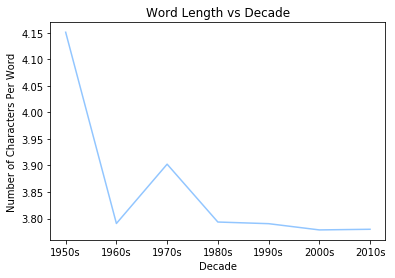

In [82]:
plt.plot(music["Decade"], music["Avg Character Count"]/music["Avg Word Count"])
plt.ylabel("Number of Characters Per Word")
plt.xlabel("Decade")
plt.title("Word Length vs Decade");
#plt.savefig("wordlenvsdecade.tiff")

### Number of Words

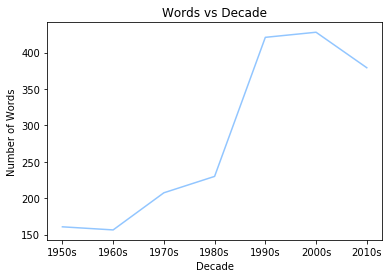

In [83]:
plt.plot(music["Decade"], music["Avg Word Count"])
plt.ylabel("Number of Words")
plt.xlabel("Decade")
plt.title("Words vs Decade");
#plt.savefig("wordsvsdecade.tiff")

## Parts of Speech

In [84]:
decade_pov_single_1 = []
decade_pov_plural_1 = []
decade_pov_2 = []
decade_male = []
decade_female = []
decade_pov_inc = []
decade_pov_ego = []
first_person_single = ["i", "me", "my", "myself", "mine"]
first_person_plural = ["we", "us", "our", "ours"]
second_person = ["you", "your", "yours", "yourself", "yourselves"]
male = ["he", "his", "him"]
female = ["she", "her", "hers"]
for decade in music["Lyrics by Words"]:
    
    songs_pov_single_1 = []
    songs_pov_plural_1 = []
    songs_pov_2 = []
    songs_male = []
    songs_female = []
    
    for song in decade:
        
        words_first_single = 0
        words_first_plural = 0
        words_second = 0
        words_male = 0
        words_female = 0
        
        for word in song:
            
            #Count number of words in first person singular
            if word in first_person_single:
                words_first_single += 1
                
            #Count number of words in first person plural
            if word in first_person_plural:
                words_first_plural += 1
                
            #Count number of words in second person
            if word in second_person:
                words_second += 1
                
            #Count number of male pronouns
            if word in male:
                words_male += 1
                
            #Count number of female pronouns
            if word in female:
                words_female += 1
                
        #Put it in terms of the whole song
        song_len = len(song)
        songs_pov_single_1 += [words_first_single/song_len]
        songs_pov_plural_1 += [words_first_plural/song_len]
        songs_pov_2 += [words_second/song_len]
        songs_male += [words_male/song_len]
        songs_female += [words_female/song_len]
        
    songs_pov_single_1 = np.mean(songs_pov_single_1)
    songs_pov_plural_1 = np.mean(songs_pov_plural_1)
    songs_pov_2 = np.mean(songs_pov_2)
    songs_male = np.mean(songs_male)
    songs_female = np.mean(songs_female)
    
    #Find the mean in each decade
    decade_pov_single_1 += [songs_pov_single_1]
    decade_pov_plural_1 += [songs_pov_plural_1]
    decade_pov_2 += [songs_pov_2]
    decade_male += [songs_male]
    decade_female += [songs_female]
    decade_pov_inc += [songs_pov_plural_1 + songs_pov_2]
    decade_pov_ego += [songs_pov_single_1 + songs_pov_plural_1]

In [85]:
def pos_counter(pos_tag):
    
    pos = []
    freq = []
    
    for _, tag in pos_tag:
        
        if tag not in pos:
            pos += [tag]
            freq += [1]
        else:
            freq[pos.index(tag)] += 1
            
    freq = freq/np.sum(freq)
    return pos, freq

In [86]:
decade_pos_tag = []
decade_pos = {}

for i in np.arange(len(music["Lyrics by Words"])):
    
    decade = music["Lyrics by Words"][i]
    decade_pos_tag += [[]]
    decade_dict = {}
    
    #Populate the dictionary of the decade with the POS frequencies for each song
    for j in np.arange(len(decade)):
        
        song = decade[j]
        decade_pos_tag[i] += [pos_tag(song)]
        pos = pos_counter(decade_pos_tag[i][j])
        label = pos[0]
        freq = pos[1]
        
        for label, freq in zip(label, freq):
            
            if label in decade_pos:
                decade_dict[label] += [freq]
            else:
                decade_dict[label] = [freq]
                
    #Combine each song's frequencies into a mean
    for item in decade_dict:
        decade_dict[item] = np.mean(decade_dict[item])
        
    #Add it to the decade_pos dictionary
    decade_pos[music["Decade"][i]] = decade_dict

In [87]:
#WDT: wh-determiner, which
#WP: wh-pronoun, who, what
#WP$: possessive wh-pronoun, whose
#WRB: wh-abverb, where, when
decade_spec = []

#PRP: personal pronoun, I, he, she
decade_prp = []

#PRP$: possessive pronoun, my, his, hers
decade_prps = []

#PRP + PRP$
decade_prgen = []

for decade in decade_pos:
    
    pos = decade_pos[decade]
    
    prp = 0
    if "PRP" in pos:
        prp = pos["PRP"]
    decade_prp += [prp]  
    
    prps = 0
    if "PRP$" in pos:
        prps = pos["PRP$"]
    decade_prps += [prps] 
    
    decade_prgen += [prp + prps]
    
    spec = 0
    if "WDT" in pos:
        spec += pos["WDT"]
    if "WP" in pos:
        spec += pos["WP"]
    if "WP$" in pos:
        spec += pos["WP$"]
    if "WRB" in pos:
        spec += pos["WRB"]
    decade_spec += [spec]

In [88]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None

In [89]:
def lemmatize(word, tag):
    
    tag = get_wordnet_pos(tag)
    
    if tag:
        return lemmatizer.lemmatize(word, tag)
    else:
        return lemmatizer.lemmatize(word)

In [90]:
stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()

unique_lyrics = []
unique_lyrics_no_stopwords = []

for i in np.arange(len(music)):
    
    decade = decade_pos_tag[i]
    unique_lyrics += [[]]
    unique_lyrics_no_stopwords += [[]]
    
    for j in np.arange(len(decade)):
        
        song = decade[j]
        
        #lemmatize words. I removed punctuations so i'll -> ill != i != ive
        unique_lyrics[i] += [set([lemmatize(word, tag) for (word, tag) in song])]
        
    #remove stopwords from unique_lyrics' entry.
    unique_lyrics_no_stopwords[i] += [[w for w in song if not w in stop_words] for song in unique_lyrics[i]] 

In [91]:
#find the average number of unique words (with and without stopwords)
len_unique = []
len_unique_no_stop = []

for i in np.arange(len(music)):
    
    decade = unique_lyrics[i]
    decade_no_stop = unique_lyrics_no_stopwords[i]
    
    unique = []
    unique_no_stop = []
    
    for j in np.arange(len(decade)):
        
        unique += [len(decade[j])]
        unique_no_stop += [len(decade_no_stop[j])]
        
    len_unique += [np.mean(unique)]
    len_unique_no_stop += [np.mean(unique_no_stop)]
len_unique = len_unique/music["Avg Word Count"]
len_unique_no_stop = len_unique/music["Avg Word Count"]

## Visualization
### Parts of Speech

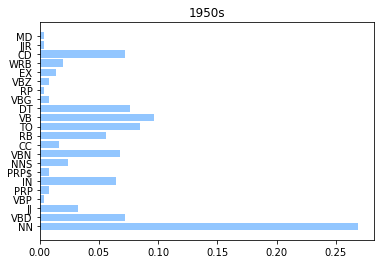

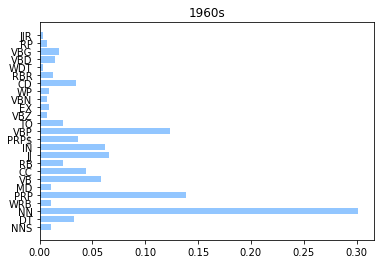

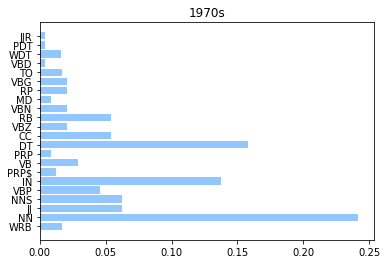

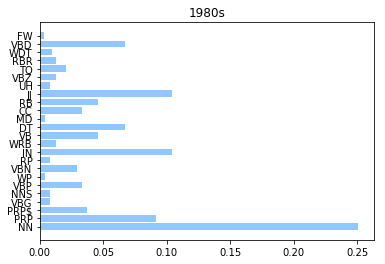

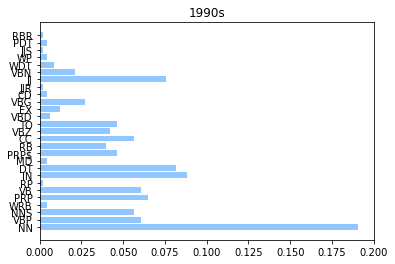

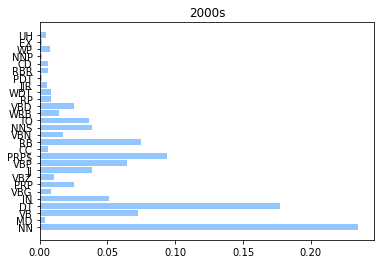

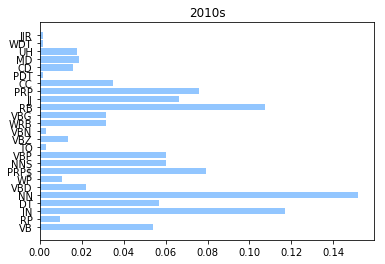

In [92]:
for decade in decade_pos:
    plt.title(decade)
    plt.barh(list(decade_pos[decade].keys()), list(decade_pos[decade].values()))
    plt.show();
    #plt.savefig(decade+"pos.tiff")

### Speculative Words

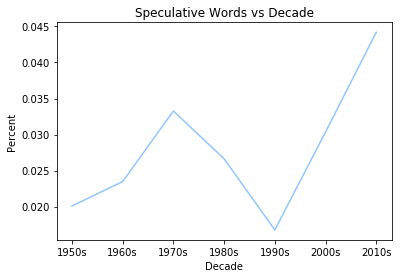

In [93]:
plt.plot(music["Decade"], decade_spec)
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.title("Speculative Words vs Decade");
#plt.savefig("specvsdecade.tiff")

### Personal Pronouns

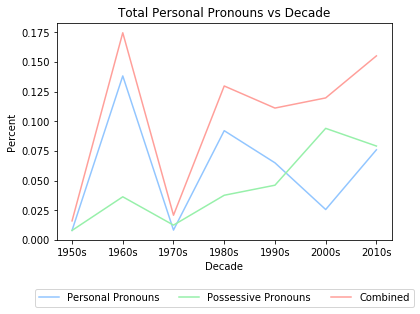

In [94]:
plt.plot(music["Decade"], decade_prp, label="Personal Pronouns")
plt.plot(music["Decade"], decade_prps, label="Possessive Pronouns")
plt.plot(music["Decade"], decade_prgen, label="Combined")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Total Personal Pronouns vs Decade");
#plt.savefig("prpvsdecade.tiff")

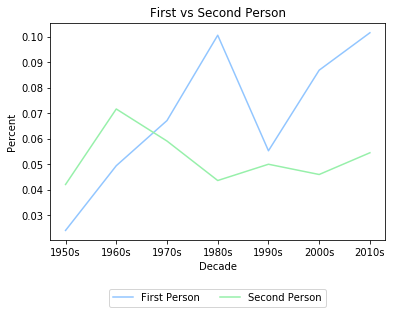

In [95]:
plt.plot(music["Decade"], decade_pov_ego, label="First Person")
plt.plot(music["Decade"], decade_pov_2, label="Second Person")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("First vs Second Person");
#plt.savefig("firstvssecond.tiff")

### Intimacy

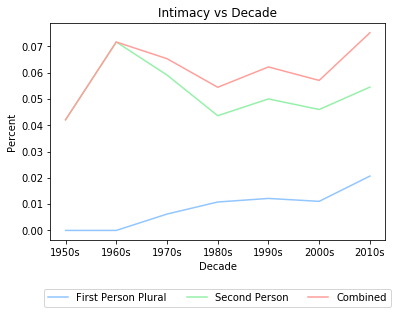

In [96]:
plt.plot(music["Decade"], decade_pov_plural_1, label="First Person Plural")
plt.plot(music["Decade"], decade_pov_2, label="Second Person")
plt.plot(music["Decade"], decade_pov_inc, label="Combined")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Intimacy vs Decade");
#plt.savefig("intimvsdecade.tiff")

### Egocentricity

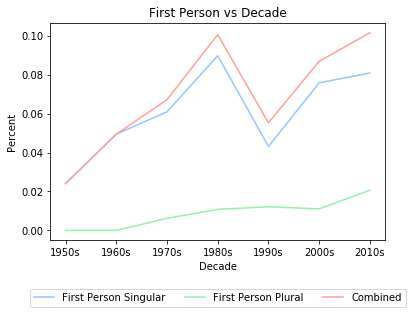

In [97]:
plt.plot(music["Decade"], decade_pov_single_1, label="First Person Singular")
plt.plot(music["Decade"], decade_pov_plural_1, label="First Person Plural")
plt.plot(music["Decade"], decade_pov_ego, label="Combined")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("First Person vs Decade");
#plt.savefig("firstvsdecade.tiff")

### Gendered Pronouns

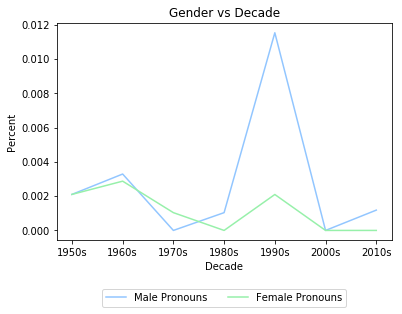

In [98]:
plt.plot(music["Decade"], decade_male, label="Male Pronouns")
plt.plot(music["Decade"], decade_female, label="Female Pronouns")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Gender vs Decade");
#plt.savefig("gendervsdecade.tiff")

### Uniqueness (Lexical Diversity)

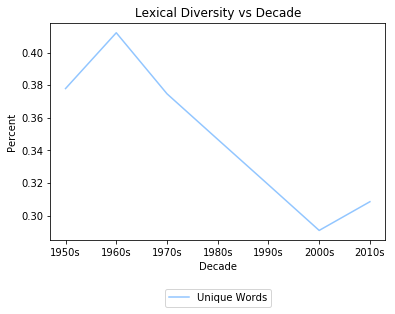

In [99]:
plt.plot(music["Decade"], len_unique, label="Unique Words")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Lexical Diversity vs Decade");
#plt.savefig("uniquestopvsdecade.tiff")

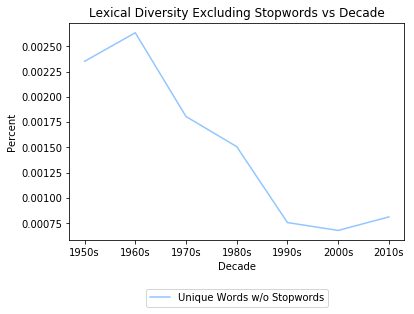

In [100]:
plt.plot(music["Decade"], len_unique_no_stop, label="Unique Words w/o Stopwords")
plt.ylabel("Percent")
plt.xlabel("Decade")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title("Lexical Diversity Excluding Stopwords vs Decade");
#plt.savefig("uniquenostopvsdecade.tiff")

## Network Graph

In [155]:
#List of all nodes
all_nodes = []

decades = music["Decade"]
#Removes duplicate years
years = set(data["Year"])
songs = data["Song"]
#Removes quotes around song titles
songs = [song[1:-1] for song in songs]
unique_words_no_stop = unique_lyrics_no_stopwords

all_nodes.extend(decades)
all_nodes.extend(years)
all_nodes.extend(songs)
for decade in unique_words_no_stop:
    for song in decade:
        all_nodes.extend(song)
        
node_type = []
node_type += ["Decade"] * len(decades)
node_type += ["Year"] * len(years)
node_type += ["Song"] * len(songs)
node_type += ["Words"] * (len(all_nodes) - len(node_type))

all_nodes = pd.DataFrame(data={"Id":all_nodes, "Label":all_nodes, "Type":node_type})
print(all_nodes.shape)
all_nodes.head()

(1862, 3)


,Id,Label,Type
0,1950s,1950s,Decade
1,1960s,1960s,Decade
2,1970s,1970s,Decade
3,1980s,1980s,Decade
4,1990s,1990s,Decade


In [153]:
#List of all edges
src = []
tgt = []

#Edges from years to the decade
points_in_decade = sum(data["Year"].isin(np.arange(data["Year"][0], data["Year"][0] + 10)))
start = 0
for year in decades:
    src += list(data["Year"][start:start + points_in_decade])
    tgt += [year] * points_in_decade
    start += points_in_decade
    
#Edges from songs to years
src += songs
tgt += list(data["Year"])

#Edges from unique words to song
song_ind = 0
for i in np.arange(len(music)):
    
    decade_lyrics = unique_lyrics_no_stopwords[i]
    
    for j in np.arange(len(decade_lyrics)):
        lyrics = decade_lyrics[j]
        src += lyrics
        tgt += [songs[song_ind]] * len(lyrics)
        song_ind += 1

all_edges = pd.DataFrame(data={"Id":np.arange(len(src)), "Source":src, "Target":tgt})
print(all_edges.shape)
all_edges.head()

(1869, 3)


,Id,Source,Target
0,0,1950,1950s
1,1,1950,1950s
2,2,1955,1950s
3,3,1955,1950s
4,4,1960,1960s


In [150]:
all_nodes.to_csv("lyric_nodes.csv",index=False)
all_edges.to_csv("lyric_edges.csv",index=False)

## Visualization
### Gephi
## Frequency Analysis
## Visualization
### Most Frequent Words
#### Overall
#### By Decade
## Sentiment Analysis
## Visualization
## TF-IDF
## Visualization
Word cloud
# Conclusion
It appears over time, words become shorter, but there are more words. That means songs have become snappier. I hypothesize the tempo of songs present-day is faster and perhaps there is a genre shift, but as I only have the song lyrics to work with, I cannot confirm my hypothesis.

There appears to be a shift from the songs focusing on "you," to convey intimacy, to "me," a more ego-centric point of view. Inclusive first person pronouns such as "we" and "us" are on the rise in the later years, implying a greater focus on the self and how the self relates to the outside world.
# What Next?
G)   5 points: What does it all mean? What did you find? What did you learn? What would you have done
differently if you had unlimited time and money? Where should future research go? (take-home points)

In [ ]:
songs_freq

In [ ]:
full_lyrics = music["Lyrics"]
music["Lyrics"] = full_lyrics
music["Word Count"] = [len(song.split()) for song in music["Lyrics"]]
music["Character Count"] = [len(song) for song in music["Lyrics"]]
lyrics_by_sentence = [sent_tokenize(song) for song in music["Lyrics"]] #save for later
music["Lyrics"] = [word_tokenize(song) for song in music["Lyrics"]]
#lyrics_by_sentence = each element's element is a sentence
#lyrics = each element's element is a word
music

In [ ]:
songs_pos = []
songs_freq = []
spec_freq = []
prp_freq = []
prpp_freq = []
personal_freq = []
for i in np.arange(len(music)):
    song = music["Lyrics"][i]
    songs_pos += [pos_tag(song)]
    songs_freq += [nltk.FreqDist([tag for (word, tag) in songs_pos[i]])]
    spec_freq += [songs_freq[i].freq("WDT") + songs_freq[i].freq("WP") + songs_freq[i].freq("WP$") + songs_freq[i].freq("WRB")]
    prp_freq += [songs_freq[i].freq("PRP")]
    prpp_freq += [songs_freq[i].freq("PRP$")]
    personal_freq += [songs_freq[i].freq("PRP") + songs_freq[i].freq("PRP$")]
music["Personal Frequency"] = personal_freq #frequency of personal pronouns and possessive personal pronouns

In [ ]:
stop_words = set(stopwords.words('english')) 
music["Lyrics"] = [[w for w in song if not w in stop_words] for song in music["Lyrics"]] 

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiments = ["positive", "neutral", "negative"]
sentiment_summary = dict([("positive", []), ("neutral", []), ("negative", [])])
for i in np.arange(len(music)):
    song = music["Lyrics"][i]
    for key in sentiments:
        sentiment_summary[key] += [0]
    for sentence in song:
        sentiment_score = sid.polarity_scores(sentence)
        if sentiment_score["compound"] == 0.0:
            sentiment_summary["neutral"][i] += 1
        elif sentiment_score["compound"] > 0.0:
            sentiment_summary["positive"][i] += 1
        else:
            sentiment_summary["negative"][i] += 1

In [ ]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None

In [ ]:
def lemmatize(word, tag):
    tag = get_wordnet_pos(tag)
    if tag:
        return lemmatizer.lemmatize(word, tag)
    else:
        return lemmatizer.lemmatize(word)

In [ ]:
lemmatizer = WordNetLemmatizer()
lyrics = []
for i in np.arange(len(music)):
    song = music["Lyrics"][i]
    lyrics += [[lemmatize(word, tag) for (word, tag) in songs_pos[i]]]
music["Lyrics"] = lyrics

In [ ]:
vectorizer = TfidfVectorizer()
lyrics_by_song = []
for i in np.arange(len(music)):
    lyrics_by_song += [" ".join(lyrics[i])]
tfidf = vectorizer.fit_transform(lyrics_by_song)
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
common = []
for i in np.arange(len(music)):
    print("Most common words of", music["Song"][i], "are:")
    common += [tfidf.iloc[i].sort_values(ascending=False)]
    print(tfidf.iloc[i].sort_values(ascending=False).head(), "\n")
music["Common Words"] = common

In [ ]:
for i in np.arange(len(music)):
    common[i][:5].plot(label=music["Song"][i], legend=True, yticks=np.arange(8)/10)
    plt.show()
#Greater word variety in modern age. Less repetitive.

# Sentiment Analysis
Overwhelmingly neutral sentences with the neutral sentences taking up a greater portion of the text in recent years.
Amount of positive sentiments is stable over the years except for 2000. Negative sentiments seem to swing wildly between more and less but in general has an upward trend.

In [ ]:
for sentiment in sentiments:
    plt.plot(music["Year"], sentiment_summary[sentiment], label=sentiment)
plt.ylabel("Count")
plt.xlabel("Year")
plt.title("Sentiment of Sentences vs Year");
plt.legend();
#plt.savefig("sentvsyear.tiff")

In [ ]:
plt.plot(music["Year"], sentiment_summary[sentiments[0]], label=sentiments[0])
plt.plot(music["Year"], sentiment_summary[sentiments[2]], label=sentiments[2])
plt.ylabel("Count")
plt.xlabel("Year")
plt.title("Number of Positive and Negative Sentences vs Year");
plt.legend();
#plt.savefig("posnegvsyear.tiff")

In [ ]:
for i in np.arange(len(music)):
    songs_freq[i].plot(cumulative=False, title=music["Song"][i])

In [ ]:
plt.plot(music["Year"], music["Personal Frequency"], label="Combined Frequency")
plt.plot(music["Year"], prp_freq, label="Personal Frequency")
plt.plot(music["Year"], prpp_freq, label="Posessive Personal Frequency")
plt.ylabel("Percentage")
plt.xlabel("Year")
plt.title("Frequency of Personal Pronouns vs Year")
plt.legend(loc="upper left");
#plt.savefig("ppvsyear.tiff")

In [ ]:
plt.plot(music["Year"], spec_freq)
plt.ylabel("Percentage")
plt.xlabel("Year")
plt.title("Frequency of Speculative Words vs Year");
#plt.savefig("specvsyear.tiff")

In [ ]:
lemmatizer = WordNetLemmatizer()
music["Unique Words (with stopwords)"] = [[word_tokenize(song) for song in decade]
                           for decade in music["Lyrics"]]
music["Unique Words (with stopwords)"] = [[[lemmatizer.lemmatize(word) for word in song] for song in decade] for decade in music["Unique Words (with stopwords)"]]
for x in music["Unique Words (with stopwords)"]:
    print(x, "!")

In [ ]:
All the words in each song are directed towards the song & direct songs to year to decade. Merge the words. See what words are in common.
Edge list: (ID, SRC(byID), TARGET(byID), TYPE (directed))
Node list: (ID, LBL)
